# Defenses Against Adversarial Examples on MNIST

- Feature Squeezing
- Adversarial Training
- Ensemble Adversarial Defense
- Anomaly Detection
- Randomized Smoothing



## 1. Imports

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest
from sklearn.metrics import roc_auc_score

## 2. Load MNIST and Define a Simple CNN

In [2]:
transform = transforms.Compose([
    transforms.ToTensor(),
])
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1000, shuffle=False)

class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [3]:
# Instantiate and train the model (for demonstration, train for 1 epoch)
model = SimpleCNN()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop (1 epoch for speed)
model.train()
for epoch in range(1):
    for data, target in train_loader:
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.cross_entropy(output, target)
        loss.backward()
        optimizer.step()

## 3. Evaluate Model Accuracy on Clean and Adversarial Test Set

In [4]:
def test(model, device, test_loader):
    model.eval()
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
    accuracy = 100. * correct / len(test_loader.dataset)
    print(f'Test set: Accuracy: {accuracy:.2f}%')
    return accuracy

clean_acc = test(model, device, test_loader)

Test set: Accuracy: 98.29%


## 4. FGSM Attack (for testing defenses)

In [5]:
def fgsm_attack(model, data, target, epsilon):
    data.requires_grad = True
    output = model(data)
    loss = F.cross_entropy(output, target)
    model.zero_grad()
    loss.backward()
    data_grad = data.grad.data
    perturbed_data = data + epsilon * data_grad.sign()
    perturbed_data = torch.clamp(perturbed_data, 0, 1)
    return perturbed_data

In [ ]:
model.eval()
data, target = next(iter(test_loader))
data, target = data.to(device), target.to(device)
epsilon = 0.25
perturbed_data = fgsm_attack(model, data, target, epsilon)
output = model(perturbed_data)
pred = output.argmax(dim=1)
misclassified = (pred != target)
print(f"FGSM misclassification rate: {misclassified.float().mean().item()*100:.2f}%")

FGSM misclassification rate: 81.50%


## 5. Feature Squeezing Defense
Feature squeezing reduces the input dimensionality to remove adversarial perturbations.

In [ ]:
def feature_squeezing_defense(data, method='bit_depth'):

    if method == 'bit_depth':
        # Reduce bit depth
        data_squeezed = torch.floor(data * 255 / 64) * 64 / 255
    elif method == 'spatial_smoothing':
        # Spatial smoothing
        kernel = torch.ones(1, 1, 3, 3) / 9
        data_squeezed = F.conv2d(data, kernel, padding=1)
    else:
        data_squeezed = data
    
    return torch.clamp(data_squeezed, 0, 1)

In [30]:
# Test feature squeezing defense
squeezed_data = feature_squeezing_defense(perturbed_data, 'bit_depth')
output_squeezed = model(squeezed_data)
pred_squeezed = output_squeezed.argmax(dim=1)
misclassified_squeezed = (pred_squeezed != target)
print(f"Feature squeezing defense accuracy: {(pred_squeezed == target).float().mean().item()*100:.2f}%")

Feature squeezing defense accuracy: 60.60%


### Visualization: Feature Squeezing

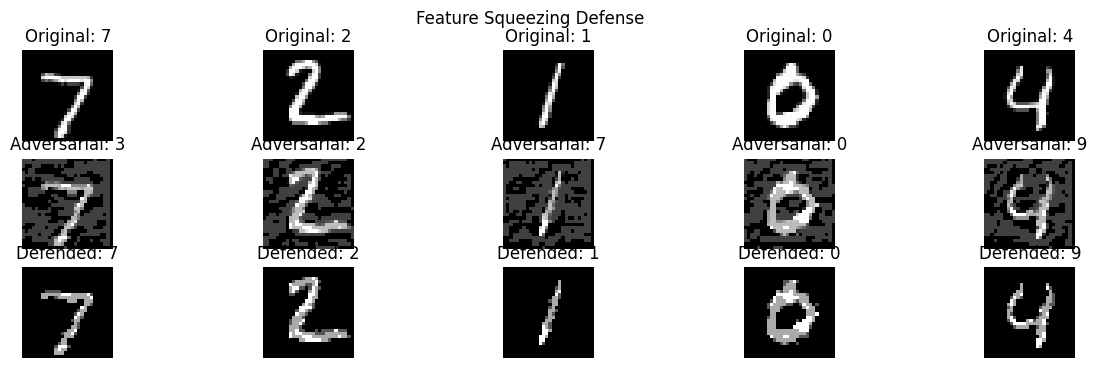

In [11]:
def plot_defense_comparison(orig, adv, defended, labels, preds_adv, preds_def, n=5):
    plt.figure(figsize=(15, 4))
    for i in range(n):
        plt.subplot(3, n, i+1)
        plt.imshow(orig[i].cpu().detach().squeeze(), cmap='gray')
        plt.title(f"Original: {labels[i].item()}")
        plt.axis('off')
        plt.subplot(3, n, n+i+1)
        plt.imshow(adv[i].cpu().detach().squeeze(), cmap='gray')
        plt.title(f"Adversarial: {preds_adv[i].item()}")
        plt.axis('off')
        plt.subplot(3, n, 2*n+i+1)
        plt.imshow(defended[i].cpu().detach().squeeze(), cmap='gray')
        plt.title(f"Defended: {preds_def[i].item()}")
        plt.axis('off')
    plt.suptitle('Feature Squeezing Defense')
    plt.show()

plot_defense_comparison(data, perturbed_data, squeezed_data, target, pred, pred_squeezed)

## 6. Adversarial Training Defense
Train the model on adversarial examples to improve robustness.

In [ ]:
# Adversarial training loop
adv_model = SimpleCNN().to(device)
optimizer = optim.Adam(adv_model.parameters(), lr=0.001)
adv_model.train()
for epoch in range(10):
    for data, small_target in train_loader:
        data, small_target = data.to(device), target.to(device)
        adv_data = fgsm_attack(adv_model, data, small_target, epsilon)
        optimizer.zero_grad()
        output = adv_model(adv_data)
        loss = F.cross_entropy(output, target)
        loss.backward()
        optimizer.step()

    print(f"Epoch {epoch} Loss: {loss}")

Epoch 0 Loss: 0.554328978061676
Epoch 1 Loss: 0.37241286039352417
Epoch 2 Loss: 0.49240145087242126
Epoch 3 Loss: 0.3296876847743988
Epoch 4 Loss: 0.13544423878192902
Epoch 5 Loss: 0.2668616473674774
Epoch 6 Loss: 0.20488855242729187
Epoch 7 Loss: 0.0369599424302578
Epoch 8 Loss: 0.22055764496326447
Epoch 9 Loss: 0.109855055809021


In [13]:
print("Adversarially trained model on clean test set:")
adv_clean_acc = test(adv_model, device, test_loader)

Adversarially trained model on clean test set:
Test set: Accuracy: 93.73%


In [31]:
target.shape[0]

1000

In [32]:
# Evaluate on adversarial test set
adv_model.eval()
small_data = data  
small_target = target
small_perturbed = perturbed_data  
output_adv = adv_model(perturbed_data)
pred_adv = output_adv.argmax(dim=1)
misclassified_adv = (pred_adv != target)
print(f"FGSM misclassification rate (adversarial training): {misclassified_adv.float().mean().item()*100:.2f}%")

FGSM misclassification rate (adversarial training): 9.90%


## 7. Ensemble Adversarial Defense
Use multiple models to improve robustness.

In [15]:
# Create ensemble of models
ensemble_models = []
for i in range(3):
    model_i = SimpleCNN().to(device)
    optimizer = optim.Adam(model_i.parameters(), lr=0.001)
    
    # Train each model slightly differently - ensemble
    model_i.train()
    for epoch in range(1):
        for data, target in train_loader:
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model_i(data)
            loss = F.cross_entropy(output, target)
            loss.backward()
            optimizer.step()
    
    ensemble_models.append(model_i)

In [16]:
# Ensemble prediction
def ensemble_predict(models, data):
    predictions = []
    for model in models:
        model.eval()
        with torch.no_grad():
            output = model(data)
            pred = output.argmax(dim=1)
            predictions.append(pred)
    
    # Majority voting
    predictions = torch.stack(predictions, dim=0)
    ensemble_pred = torch.mode(predictions, dim=0)[0]
    return ensemble_pred

In [17]:
# Test ensemble defense
ensemble_pred = ensemble_predict(ensemble_models, small_perturbed)
ensemble_accuracy = (ensemble_pred == small_target).float().mean().item() * 100
print(f"Ensemble defense accuracy: {ensemble_accuracy:.2f}%")

Ensemble defense accuracy: 6.25%


## 8. Anomaly Detection Defense
Detect adversarial examples using anomaly detection.

In [18]:
# Extract features for anomaly detection
def extract_features(model, data_loader):
    features = []
    labels = []
    model.eval()
    with torch.no_grad():
        for data, target in data_loader:
            data = data.to(device)
            # Use the last layer before classification as features
            x = F.relu(model.conv1(data))
            x = F.relu(model.conv2(x))
            x = F.max_pool2d(x, 2)
            x = torch.flatten(x, 1)
            x = F.relu(model.fc1(x))
            features.append(x.cpu().numpy())
            labels.extend(target.cpu().numpy())
    
    return np.vstack(features), np.array(labels)

In [19]:
# Train anomaly detector on clean data
clean_features, clean_labels = extract_features(model, train_loader)
anomaly_detector = IsolationForest(contamination=0.1, random_state=42)
anomaly_detector.fit(clean_features)

IsolationForest(contamination=0.1, random_state=42)

In [ ]:
# Test anomaly detection on adversarial data
adv_features, adv_labels = extract_features(model, [(perturbed_data, target)])
clean_scores = anomaly_detector.decision_function(clean_features[:1000])
adv_scores = anomaly_detector.decision_function(adv_features)



Anomaly detection AUC: 0.098


### Visualization: Anomaly Detection

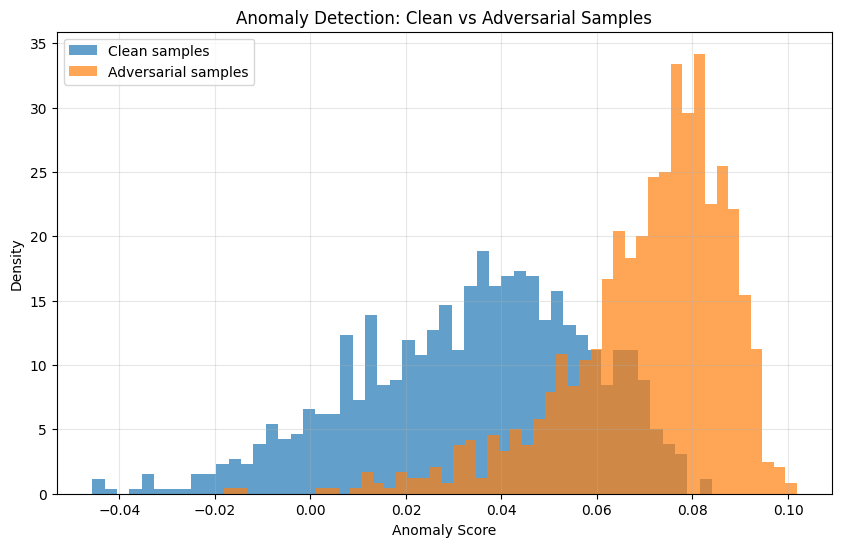

In [34]:
plt.figure(figsize=(10, 6))
plt.hist(clean_scores, bins=50, alpha=0.7, label='Clean samples', density=True)
plt.hist(adv_scores, bins=50, alpha=0.7, label='Adversarial samples', density=True)
plt.xlabel('Anomaly Score')
plt.ylabel('Density')
plt.title('Anomaly Detection: Clean vs Adversarial Samples')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

## 9. Randomized Smoothing Defense
Use randomized smoothing to improve robustness.

In [ ]:
def randomized_smoothing_predict(model, data, n_samples=100, sigma=0.25):
    """
    Randomized smoothing prediction
    """
    model.eval()
    predictions = []
    
    for _ in range(n_samples):
        # Add Gaussian noise
        noise = torch.randn_like(data) * sigma
        noisy_data = torch.clamp(data + noise, 0, 1)
        
        with torch.no_grad():
            output = model(noisy_data)
            pred = output.argmax(dim=1)
            predictions.append(pred)
    
    # Majority vote
    predictions = torch.stack(predictions, dim=0)
    smoothed_pred = torch.mode(predictions, dim=0)[0]
    return smoothed_pred